In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from torch import Tensor
from typing import Tuple, Callable
from itertools import chain
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

scaler = GradScaler(device)

Using cuda device


/tmp/ipykernel_41175/3266725043.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(device)


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    # download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    # download=True,
    transform=ToTensor(),
)

In [4]:
target_label = 0
training_data_incides = torch.where(training_data.targets == target_label)[0]
test_data_incides = torch.where(test_data.targets == target_label)[0]

training_data = Subset(training_data, training_data_incides)
test_data = Subset(test_data, test_data_incides)

In [5]:
# Define validation split fraction
val_fraction = 0.1
dataset_size = len(training_data)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

# Create a reproducible shuffled list of indices
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(dataset_size, generator=generator).tolist()

# Split indices for train and validation
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap Subsets for train and validation datasets
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

In [6]:
def preprocess_data(x):
    """Preprocess images for normalizing flow training"""
    # Add uniform noise for dequantization (important for discrete data)
    x = x + torch.rand_like(x) / 256.0
    # Logit transform to map [0,1] to real numbers
    x = torch.clamp(x, 1e-6, 1 - 1e-6)  # Avoid log(0)
    x = torch.log(x) - torch.log(1 - x)  # logit transform
    return x

In [7]:
class DataLoaderWrapper:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


def to_device(x: Tensor, y: Tensor) -> Tensor:
    return x.to(device), y.to(device)

In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoaderWrapper(DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True), to_device)
val_dataloader = DataLoaderWrapper(DataLoader(training_data, batch_size=batch_size), to_device)
test_dataloader = DataLoaderWrapper(DataLoader(test_data, batch_size=batch_size), to_device)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


$$
z_B = \exp\left(-s(z_A)\right) \odot \left(x_B - b(z_A)\right)  
$$

$$
J = 
\begin{bmatrix}
I_d & 0 \\
\frac{\partial z_B}{\partial x_A} & \mathrm{diag}\big(\exp(-s)\big)
\end{bmatrix}
$$

$$
x_B = \exp\big(s(z_A, w)\big) \odot z_B + b(z_A, w)
$$

In [9]:
class CouplingLayer(nn.Module):
    def __init__(
        self,
        split_at: int,
        scale_net: nn.Module, # s
        shift_net: nn.Module, # b
        alternate_parts: bool = False
    ) -> None:
        super().__init__()
        self.split_at = split_at
        self.scale_net = scale_net
        self.shift_net = shift_net
        self.alternate_parts = alternate_parts
    

    def _split(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        if self.alternate_parts:
            return x[:, self.split_at:], x[:, :self.split_at]
        else:
            return x[:, :self.split_at], x[:, self.split_at:]


    def _merge(self, xA: Tensor, xB: Tensor) -> Tensor:
        if self.alternate_parts:
            return torch.cat((xB, xA), dim=1)
        else:
            return torch.cat((xA, xB), dim=1)


    def _get_scale_and_shift(self, zA: Tensor) -> Tuple[Tensor, Tensor]:
        log_scale = self.scale_net(zA)
        log_scale = torch.clamp(log_scale, min=-5, max=3)
        shift = self.shift_net(zA)
        return log_scale, shift


    def forward(self, x: Tensor, log_det_total: Tensor) -> Tuple[Tensor, Tensor]:
        xA, xB = self._split(x)
        zA = xA
        log_scale, shift = self._get_scale_and_shift(zA)

        zB = torch.exp(-log_scale) * (xB - shift)
        z = self._merge(zA, zB)

        log_det_current = -torch.sum(log_scale, dim=1)
        log_det_total = log_det_total + log_det_current
        return z, log_det_total


    def inverse(self, z: Tensor) -> Tensor:
        zA, zB = self._split(z)
        xA = zA
        log_scale, shift = self._get_scale_and_shift(zA)

        xB = torch.exp(log_scale) * (zB + shift)
        x = self._merge(xA, xB)
        return x

In [10]:
class MLP(nn.Module):
    def __init__(self,
        layers_dims: list,
        activation_layer: nn.Module = nn.ReLU(),
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        super().__init__()
        assert len(layers_dims) > 2
        layers = []
        
        for in_features, out_features in zip(layers_dims[:-2], layers_dims[1:-1]):
            layers.append(nn.Linear(in_features, out_features, bias=bias, device=device, dtype=dtype))
            layers.append(copy.deepcopy(activation_layer))
        
        layers.append(nn.Linear(layers_dims[-2], layers_dims[-1], bias=bias, device=device, dtype=dtype))

        # Init last layer to small values for stability
        nn.init.zeros_(layers[-1].weight)
        if bias:
            nn.init.zeros_(layers[-1].bias)
            
        self.model = nn.Sequential(*layers)
        

    def forward(self, x) -> Tensor:
        return self.model(x)
        

In [11]:
class Conv2dActivationStack(nn.Module):
    def __init__(
        self,
        num_of_layers: int,
        in_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: int = 1,
        activation_layer: nn.Module = nn.ReLU(),
        bias: bool = True,
        device=None,
        dtype=None,
        input_is_flat: bool = False,      # New flag
        image_shape: tuple[int, int, int] = None  # (C, H, W)
    ) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.activation_layer = activation_layer
        self.input_is_flat = input_is_flat
        self.image_shape = image_shape

        layers = chain.from_iterable(
            (
                nn.Conv2d(
                    in_channels,
                    in_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    bias=bias,
                    device=device,
                    dtype=dtype,
                ),
                # Clone to avoid shared state
                copy.deepcopy(activation_layer) 
            )
            for _ in range(num_of_layers)
        )
        self.model = nn.Sequential(*layers)

        if self.input_is_flat:
            assert (
                self.image_shape is not None
            ), "Must provide image_shape if input_is_flat is True"

    def forward(self, x: Tensor) -> Tensor:
        if self.input_is_flat:
            # reshape flat vector to image tensor
            B = x.size(0)
            x = x.view(B, *self.image_shape)  # (B, C, H, W)

        x = self.model(x)

        if self.input_is_flat:
            # flatten back to vector
            B = x.size(0)
            x = x.view(B, -1)  # (B, C*H*W)

        return x



In [12]:
class LambdaLayer(nn.Module):
    def __init__(
        self,
        func: Callable[[Tensor], Tensor],
        inv_func: Callable[[Tensor], Tensor],
    ) -> None:
        super().__init__()
        self.func = func
        self.inv_func = inv_func

    def forward(self, x: Tensor, *args, **kwargs):
        y = self.func(x)
        if args or kwargs:
            return (y, *args) if not kwargs else (y, *args, kwargs)
        return y
    
    def inverse(self, x: Tensor) -> Tensor:
        return self.inv_func(x)


def vec_to_img(x: Tensor) -> Tensor:
    return x.view(-1, 1, 28, 28)

def img_to_vec(x: Tensor) -> Tensor:
    return x.flatten(1)


def sigmoid_inverse(x: Tensor):
    # Avoid log(0)
    x = torch.clamp(x, 1e-6, 1 - 1e-6)
    x = torch.log(x) - torch.log(1 - x)
    return x

def add_noise(x: Tensor):
    # Add uniform noise for dequantization (important for discrete data)
    return x + torch.rand_like(x) / 256.0


In [13]:
class FlowSequential(nn.Module):
    def __init__(self, *modules: nn.Module):
        super().__init__()
        self.modules_list = nn.ModuleList(modules)

        # Check if all modules implement required interface
        for i, module in enumerate(self.modules_list):
            if not hasattr(module, 'forward') or not hasattr(module, 'inverse'):
                raise TypeError(f"Module at index {i} must implement both 'forward' and 'inverse' methods.")

    def forward(
        self,
        x: torch.Tensor,
        log_det:
        torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        for module in self.modules_list:
            x, log_det = module(x, log_det)
        return x, log_det

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        for module in reversed(self.modules_list):
            z = module.inverse(z)
        return z
    
    def __call__(
        self,
        x: torch.Tensor,
        log_det: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Optional: put extra logic here before/after forward
        return self.forward(x, log_det)

In [14]:
NORMAL_DIST_CONST = torch.log(torch.tensor(2 * torch.pi, device=device))
def normal_NLL(X: Tensor) -> Tensor:
    """Compute -log p(z) for standard Gaussian"""
    d = X.shape[1]
    const_term = (d / 2) * NORMAL_DIST_CONST.to(X.device)
    squared_term = 0.5 * X.pow(2).sum(dim=1)
    return const_term + squared_term


def flow_NLL_loss(
    z_sample: Tensor,
    total_log_det: Tensor,
) -> Tensor:
    """Flow loss = base NLL - total log det (averaged)"""
    return torch.mean(normal_NLL(z_sample) - total_log_det)

In [15]:
x_sample = next(iter(train_dataloader))[0].to(device)

In [16]:
def sample_model(model, num_samples, dim):
    # Sample from normal distribution
    model.eval()
    z = torch.randn((num_samples, dim)).to(device)
    
    with torch.no_grad():
        x = model.inverse(z)
        
    model.train()
    return x

In [17]:
def visualize_samples(x: Tensor, epoch=None):
    """Visualize samples from the trained model"""
    # Plot samples
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i], cmap='gray')
        ax.axis('off')
    
    title = f'Generated Samples - Epoch {epoch}' if epoch else 'Generated Samples'
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for suptitle
    plt.show()

In [18]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    with torch.amp.autocast(device_type=device):
        zb, total_log_det = model(xb, 0)
        loss = loss_func(zb, total_log_det)

    if opt is not None:
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(num_epochs, model, loss_func, opt, scheduler, train_dl, valid_dl):
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (xb, yb) in tqdm(enumerate(train_dl), desc=f'Epoch {epoch + 1}/{num_epochs}', total=len(train_dl)):
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        val_loss_sum = 0
        val_num = 0
        with torch.no_grad():
            for xb, yb in valid_dl:
                loss, num = loss_batch(model, loss_func, xb, yb)
                val_loss_sum += loss * num
                val_num += num
        val_loss = val_loss_sum / val_num

        scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}: Loss: {val_loss:.4f}')

        if (epoch + 1) % 5 == 0:
            z = sample_model(model, 4, 784).squeeze(1).to('cpu').numpy()
            visualize_samples(z, epoch + 1)

In [19]:
model = FlowSequential(
    LambdaLayer(sigmoid_inverse, torch.sigmoid),
    LambdaLayer(img_to_vec, vec_to_img),
    LambdaLayer(add_noise, lambda x: x),
    CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
    CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
    CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
    CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
    CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
    CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),

).to(device)


In [24]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)

Epoch 1/50: 100%|██████████| 94/94 [00:01<00:00, 59.63it/s]


Epoch 1/50: Loss: 2847.1701


Epoch 2/50: 100%|██████████| 94/94 [00:01<00:00, 77.40it/s]


Epoch 2/50: Loss: 2115.4492


Epoch 3/50: 100%|██████████| 94/94 [00:01<00:00, 78.12it/s]


Epoch 3/50: Loss: 1962.4874


Epoch 4/50: 100%|██████████| 94/94 [00:01<00:00, 79.28it/s]


Epoch 4/50: Loss: 1864.2456


Epoch 5/50: 100%|██████████| 94/94 [00:01<00:00, 79.15it/s]


Epoch 5/50: Loss: 1767.7914


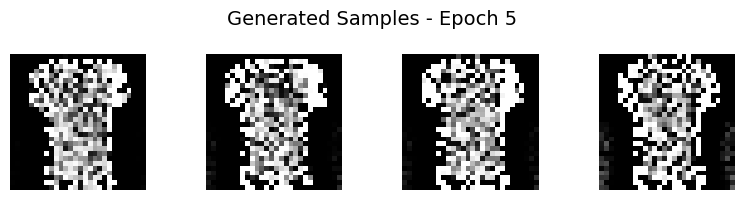

Epoch 6/50: 100%|██████████| 94/94 [00:01<00:00, 76.17it/s]


Epoch 6/50: Loss: 1688.6350


Epoch 7/50: 100%|██████████| 94/94 [00:01<00:00, 78.17it/s]


Epoch 7/50: Loss: 1632.3420


Epoch 8/50: 100%|██████████| 94/94 [00:01<00:00, 73.62it/s]


Epoch 8/50: Loss: 1596.4252


Epoch 9/50: 100%|██████████| 94/94 [00:01<00:00, 67.49it/s]


Epoch 9/50: Loss: 1562.1869


Epoch 10/50: 100%|██████████| 94/94 [00:01<00:00, 69.78it/s]


Epoch 10/50: Loss: 1536.7242


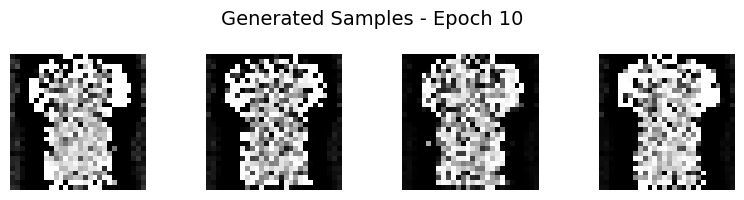

Epoch 11/50: 100%|██████████| 94/94 [00:01<00:00, 68.60it/s]


Epoch 11/50: Loss: 1510.8598


Epoch 12/50:  18%|█▊        | 17/94 [00:00<00:01, 59.39it/s]


KeyboardInterrupt: 

In [25]:
fit(50, model, flow_NLL_loss, opt, scheduler, train_dataloader, val_dataloader)

In [29]:
z_sample = torch.randn((1,784)).to(device)
z_sample_inv = torch.sigmoid(model.inverse(z_sample)).detach().cpu().numpy()

TypeError: Invalid shape () for image data

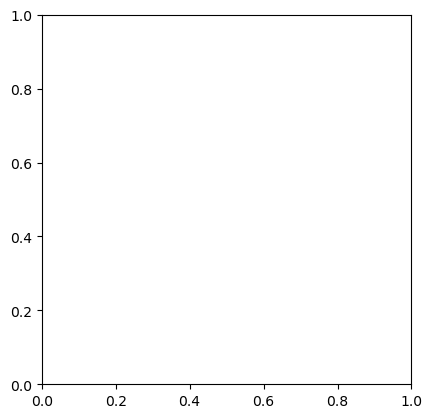

In [30]:
plt.imshow(z_sample_inv[0][0], cmap="gray")